# Effect of cross-validation on distance estimators

This notebook demonstrates the influence of measurement noise on 
distance measures (representational geometry) and on model selection. 

In [53]:
import seaborn as sb
import matplotlib.pyplot as plt
from sim_crossval import crossval_sim
import scipy.spatial.distance as sd
import numpy as np
import pandas as pd
import rsatoolbox as rsa

In [63]:
def plot_panel(T):
    """ Plot the violin plots of the results """
    sb.violinplot(data=T,x='Trued',y='Simp',inner='quart',color='red')
    sb.violinplot(data=T,x='Trued',y='Cross',inner='quart',color=[0.1,0.25,0.95])
    sb.despine()
    plt.plot([0,3],[0,3],'k--')
    plt.xlabel('True distance')
    plt.ylabel('Estimated distance')
    ax=plt.gca()
    ax.set_ylim([-2,9])

The following code generates data from an experiment with 4 conditions and 6 distances with the following RDM 

In [64]:
true_dist = np.array([2,1,0,3,2,1])
D = sd.squareform(true_dist)
D


array([[0, 2, 1, 0],
       [2, 0, 3, 2],
       [1, 3, 0, 1],
       [0, 2, 1, 0]])

We now generate data with this RDM for 2 runs (partitions). the first case, the measurement error in each run in i.i.d. 

In [65]:
T1 = crossval_sim(sigma='iid',n_sim=100)

We then repeat the same simulation with measurement error that correlates condition 1 and 2, and condition 2 and 4 (which both have distance 2) 

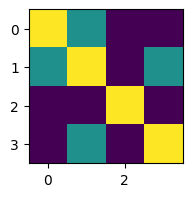

In [66]:
Sigma = [[1,0.5,0,0],[0.5,1,0,0.5],[0,0,1,0],[0,0.5,0,1]]
plt.figure(figsize=(2,2))
plt.imshow(Sigma,cmap='viridis',vmin=0,vmax=1)

In [67]:
T2 = crossval_sim(sigma='neigh',n_sim=100)

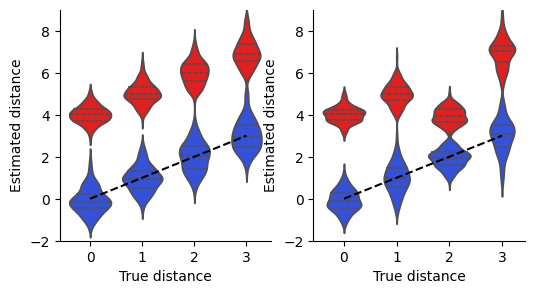

In [ ]:
# This is Figure 3c,d in the Bosch et al. (2025) paper. 
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_panel(T1)
plt.subplot(1,2,2)
plot_panel(T2)
# plt.savefig('crossval_example.pdf')

# Influence on Model comparison
How does this influence model selection?  For this we want to see how the average estimated RDM correlates or cosine-angles with the true RDM. It should be ideally close to 1, but more importantly, better than for an alternative model. 

In [70]:
def calc_model_correlation(T):
    """ Calculate correlation of the estimated distances with true distances and with an alternative model - using corr and cosine methods """
    Dtrue = T.groupby('dist_type').Trued.mean().values
    Dsimp = T.groupby('dist_type').Simp.mean().values
    Dcross = T.groupby('dist_type').Cross.mean().values
    # Make a alternative distance matrix 
    Dalt = np.array([2,2,1,5,2,3])
    for method in ['corr','cosine']:
        rtc = rsa.rdm.compare(Dtrue, Dcross, method=method)[0][0]
        rts = rsa.rdm.compare(Dtrue, Dsimp, method=method)[0][0]
        rac = rsa.rdm.compare(Dalt, Dcross, method=method)[0][0]
        ras = rsa.rdm.compare(Dalt, Dsimp, method=method)[0][0]
        print(f"\n{method}  (True, Alternative):")
        print(f"Biased distance ({rts:.2f} vs. {ras:.2f})")
        print(f"Crossvalidated distance: ({rtc:.2f} vs. {rac:.2f})")
    return

For i.i.d noise, you can use correlation on biased distances, and cosine (or correlation) on cross-validated distances 

Never use cosine angle on biased distanaces 

In [71]:
calc_model_correlation(T1)


corr  (True, Alternative):
Biased distance (1.00 vs. 0.76)
Crossvalidated distance: (1.00 vs. 0.77)

cosine  (True, Alternative):
Biased distance (0.92 vs. 0.94)
Crossvalidated distance: (1.00 vs. 0.93)


For correlated nise within a run, you need to use cross-validated distances (and ideally cosine angle, but correlation is ok).

Never use biased distances


In [72]:
calc_model_correlation(T2)


corr  (True, Alternative):
Biased distance (0.55 vs. 0.92)
Crossvalidated distance: (1.00 vs. 0.78)

cosine  (True, Alternative):
Biased distance (0.89 vs. 0.96)
Crossvalidated distance: (1.00 vs. 0.94)
